In [1]:
#===============================================================================
#===============================================================================
from math import ceil
import cv2
import numpy as np
import argparse
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import matplotlib.patches as patches
#===============================================================================
#===============================================================================

In [2]:
#===============================================================================
def get_mean(hist, size, start, end):

    '''
        Here, we count the vote for each point in histogram and divide it by
        the total number of votes castes. We sample the computed 'kernel density estimation'
        to find probability values. Then we multiply by the size to find the actual count
        for the intensity value.
    '''
    center_of_mass = 0;
    recip = 0;
    s = 0;
    #sample values from start to end increamented by 0.1
    r = np.arange(start, end, 0.1)[:, None];
    #sample actual probabilities and multiply by size to get the actual values
    samples = np.exp(hist.score_samples(r)) * size;
    #loop over entire samples
    for x, val in enumerate(samples):
        s += (val);
        center_of_mass += (x)*val;
        recip += val
    #find center of mass
    center_of_mass /= (recip + 1);

    center_of_mass = center_of_mass / 10;

    #translate seed point by center of mass and return 
    return start + center_of_mass;
#===============================================================================

#===============================================================================
def mean_shift_algorithm(kde, hist, size, seed_point, window_size):

    '''
        Implementation of the mean shift algorithm. Here, we find the peak in histogram
        by moving the window each time by the mean shift vector which points toward
        the center of the mass.
        kde: kernel densitiy estimation of the image. We use this parameter to sample probability 
        values.
        hist: the actual histogram of the image.
        size: the total number of pixels in the image. We multiply this value by each probability
        to get the actual count of the pixels for a specific intensity value.
        seed_point: the start point
        window_size: Window to search for the center of gravity.
    '''

    #represent current mean of the current window
    new_seed_point = get_mean(kde, size, (seed_point-int(window_size/2)), (seed_point + int(window_size/2)));

    #amount of threshold to detect convergence of window
    thresh_mean_diff = 5e-2;

    #loop until convergence
    while np.abs(new_seed_point - seed_point) > thresh_mean_diff:

        seed_point = new_seed_point;

        #find new mean and shift towards the new center
        new_seed_point = get_mean(kde, size, (seed_point-int(window_size/2)), (seed_point + int(window_size/2)));

        #if the number is negative, it indicates a problem and we should return
        if new_seed_point < 0:
            break;
        
    
    #round seed_point value and return
    return round(seed_point);
    
#===============================================================================

In [3]:
#===============================================================================
def relax_modes(mode):
    '''
        Remove close modes found. We assume that points found as modes
        very close to each other (difference of 10 because of window size) can be grouped together.
        Hence, we replace these points by the mean.
    '''
    relaxed_modes = [];
    idx = 0;
    avg_val = 0;
    cnt_val = 0;
    while(idx < len(mode) - 1):
        curr_val = mode[idx];
        cnt_val += 1;
        avg_val += curr_val;
        if np.abs(curr_val - mode[idx+1]) > 10:
            #we have reached the end of number strip and we have to find the mean.
            relaxed_modes.append(int(avg_val / cnt_val));
            cnt_val = 0;
            avg_val = 0;
        idx += 1;
    
    #add the final remaining value
    avg_val += mode[idx];
    relaxed_modes.append(int(avg_val / (cnt_val+1)));

    return relaxed_modes;
#===============================================================================

In [27]:
def replace_pixels_with_mode(img, modes, pos_range, neg_range):
    '''
        replace pixels in the given image with the intensities listed in 
        'modes' to generate the final segmented image.
        img: input image
        modes: modes calculated using mean shift algorithm
        pos_range: range to consider intensity values more than the given mode   
        pos_range: range to consider intensity values lower than the given mode  
    '''
    #make sure modes list is sorted
    modes = sorted(modes);

    #because we want to check a range, create a range
    #of accepted pixels intensity value for each of the modes found
    range_modes = dict();
    for m in modes:
        range_modes[m] = (np.arange(m-neg_range, m+pos_range));
    modes = np.array(modes);
    #divide the range from 0 to 255 according to number of colors we want to represent each region
    distinct_color = [];
    for i in range(len(modes)):
        distinct_color.append([np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255)]);
    distinct_color = np.array(distinct_color);
    #final segmented region
    w,h = img.shape;
    segmented_img = np.zeros((w, h, 3), dtype=np.uint8);
    #loop over entire image and replace pixels
    for i in range(w):
        for j in range(h):
            pixel_value = img[i][j];
            #if this pixel is a mode
            for rm in range_modes.keys():
                if pixel_value in range_modes[rm]:
                    #replace color value with a distinct color
                    segmented_img[i][j][:] = distinct_color[np.where(modes==rm)];
                    break;

    return segmented_img;

Use this parameters for Figure 6:
1- img_name = "MRI-heart.jpg", bandwidth = 2.8
2- img_name = "Swan.jpg", bandwidth = 4.0
3- img_name = "x-ray.jpg", bandwidth = 2.8

In [45]:

#=================================
#       Variables to be changed
#=================================
bandwidth = 4
img_name = "Swan.jpg"
#=================================
#       Variables to be changed
#=================================
img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE);

hist = cv2.calcHist([img], [0], None, [256], [0,256]);

#calculate Kernel Density Estimation (KDE)
X_plot = np.arange(256)[:, None]
kde_08 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(img.ravel()[:, None])
log_dens_08 = np.exp(kde_08.score_samples(X_plot));

#finding actual values for each intensity
hist = log_dens_08 * img.shape[0] * img.shape[1];

#set window size to search in mean shift algorithm.
window_size = 10;

mode_dict = dict();
for i in range(0,256, window_size*2):
    mode = mean_shift_algorithm(kde_08, hist, img.shape[0] * img.shape[1], i, window_size);
    mode_dict[mode] = 1;

    print(f"Progress: {(i/256)*100}", end='\r');

In [46]:
modes = np.array(list(mode_dict.keys()));
pos_indices = (modes>0);
modes = modes[pos_indices];
modes = relax_modes(modes);
print(modes);

[1, 80, 107, 148, 178, 200]


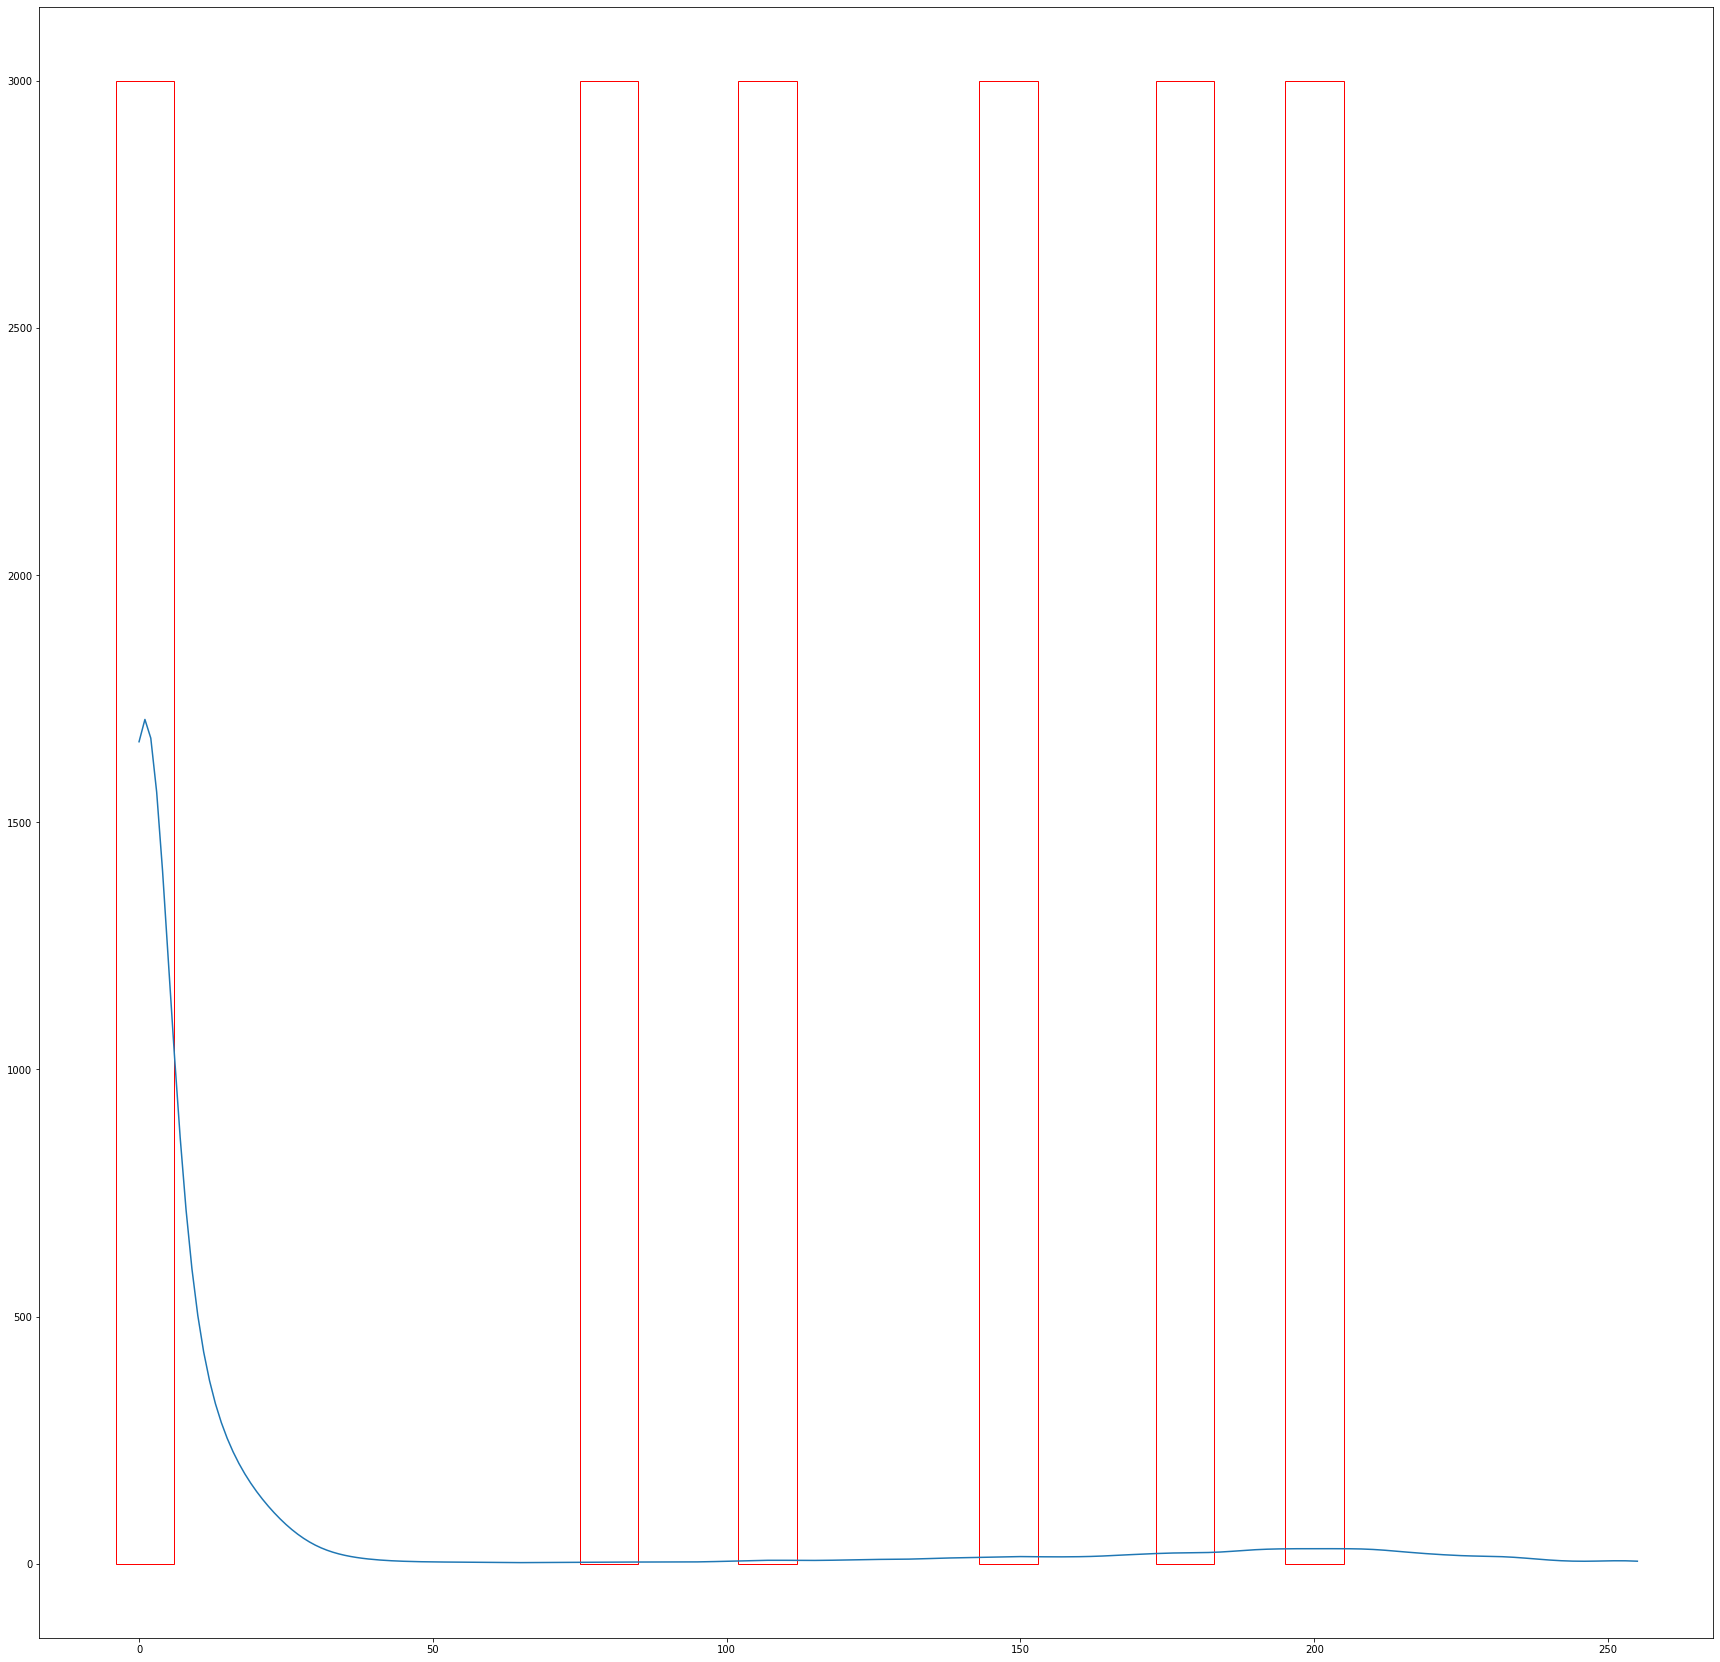

In [47]:
fig = plt.figure();
fig.set_size_inches(30,30);
ax = plt.axes();
ax.plot(hist);
for m in modes: 
    rect = patches.Rectangle((m-int(window_size/2), 0), window_size, 3000, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect);
plt.savefig("X-ray-histogram.png")

For figure 7:
MRI heart.jpg -> pos_range = 1, neg_range = 1
x-ray.jpg -> pos_range = 1, neg_range = 1
swan.jpg -> pos_range = 1, neg_range = 1


For figure 8:
MRI heart -> pos_range = 45, neg_range = 25
x-ray.jpg -> pos_range = 25, neg_range = 25
swan.jpg -> pos_range = 25, neg_range = 25

(143, 180, 3)


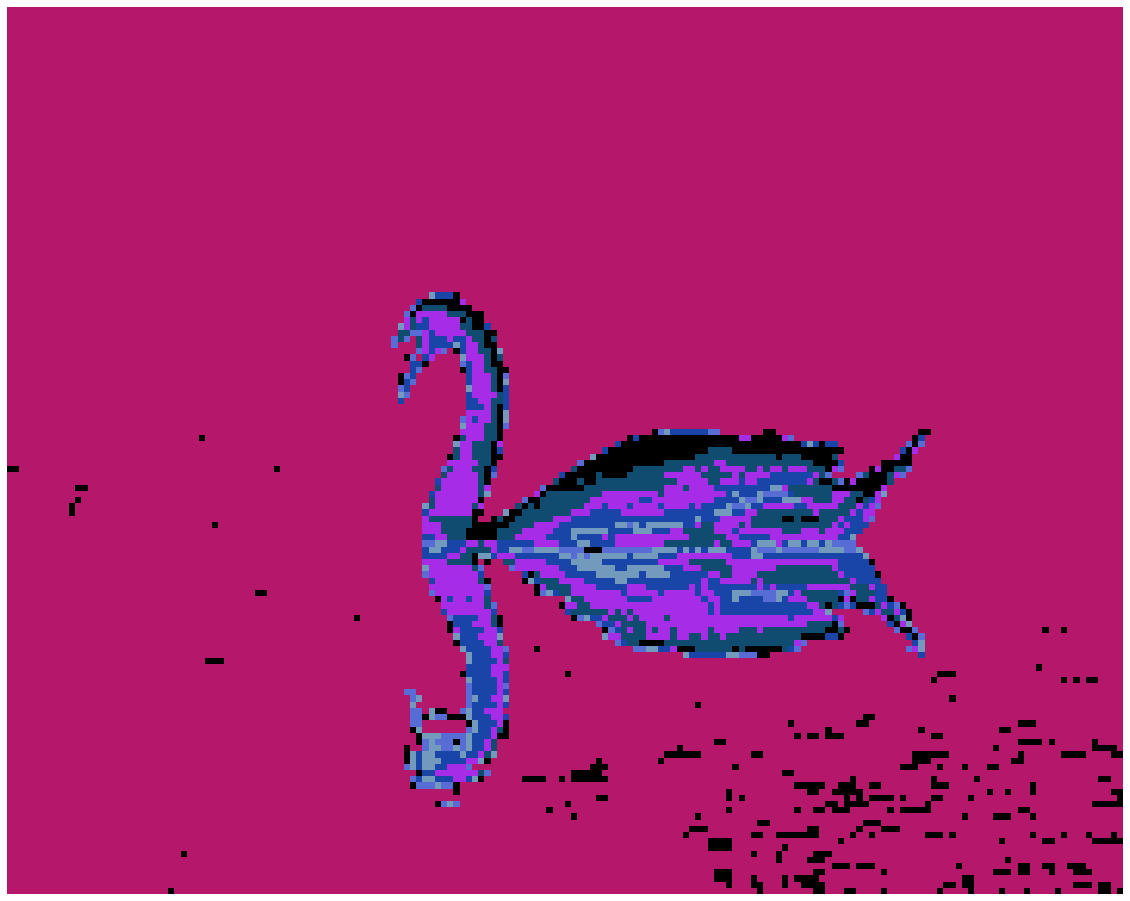

In [52]:
#=================================
#       Variables to be changed
#=================================
pos_range = 25
neg_range = 25
#=================================
#       Variables to be changed
#=================================

seg = replace_pixels_with_mode(img, modes, pos_range, neg_range);


print(seg.shape);
fig = plt.figure();
fig.set_size_inches(20,20);
ax = plt.axes();
ax.imshow(seg);
ax.set_axis_off();